## Парная торговля с помощью фильтра Калмана

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

In [2]:
# загрузим сформированный датасет цен всех ликвидных акций
df6_test = pd.read_csv('df6_tot_test.csv')
# выберем пару
tickers = ['HMY','UCTT']
df = pd.DataFrame()
for ticker in tickers:
    df[ticker] = df6_test[ticker]

In [3]:
def kalman_filter_avg(x):
    # фильтр для одного ряда
    kf = KalmanFilter(
        transition_matrices = [1],
        observation_matrices = [1],
        initial_state_mean = 0,
        initial_state_covariance = 1,
        observation_covariance=200,
        transition_covariance=0.01
    )

    # Используем наблюдаемые цены для получения скользящего среднего
    state_means, _ = kf.filter(x.values)
    ind = x.index
    return pd.Series(state_means.flatten(), index=ind)

def kalman_filter_reg(x, y, delta=1e-2):
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(
        n_dim_obs=1, 
        n_dim_state=2,
        initial_state_mean=[0,0],
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=200,
        transition_covariance=trans_cov
    )

    # Используем наблюдения y для получения текущих оценок и ошибок для параметров состояния
    state_means, _ = kf.filter(y.values)
    return state_means

In [4]:
# half-life of mean-reversion - мера того, сколько времени требуется временному ряду для возврата к среднему.
def half_life(spread):
    spr_lag = spread.shift(1)
    spr_lag.iloc[0] = spr_lag.iloc[1]

    spread_ret = spread - spr_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]

    spr_lag_ = sm.add_constant(spr_lag)

    model = sm.OLS(spread_ret, spr_lag_)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1], 0))

    if halflife <= 0:
        halflife = 1
    return halflife

In [5]:
def KF_trade(x, y, window=None):
    fee = 0.0010
    df = pd.DataFrame({"y": y, "x": x})
    state_means = kalman_filter_reg(kalman_filter_avg(x), kalman_filter_avg(y))

    df["hr"] = -state_means[:, 0]
    df["spread"] = df.y + (df.x * df.hr)
    if window == None:
        halflife = half_life(df["spread"])
        meanSpread = df.spread.rolling(window=halflife).mean()
        stdSpread = df.spread.rolling(window=halflife).std()
    else:
        halflife = 0
        meanSpread = df.spread.rolling(window=window).mean()
        stdSpread = df.spread.rolling(window=window).std()

    df["z_score"] = (df.spread - meanSpread) / stdSpread

    z_score_entry = 1
    z_score_exit = 0

    # Signals for long
    df["entry_long"] = (df.z_score < -z_score_entry) & (df.z_score.shift(1) > -z_score_entry)
    df["exit_long"] = (df.z_score > -z_score_exit) & (df.z_score.shift(1) < -z_score_exit)
    
    df["signal_long"] = np.nan
    df.loc[df["entry_long"], "signal_long"] = 1
    df.loc[df["exit_long"], "signal_long"] = 0
    df["signal_long"][0] = 0
    df["signal_long"] = df["signal_long"].fillna(method="pad")

    # Signals for short
    df["entry_short"] = (df.z_score > z_score_entry) & (df.z_score.shift(1) < z_score_entry)
    df["exit_short"] = (df.z_score < z_score_exit) & (df.z_score.shift(1) > z_score_exit)
    
    df["signal_short"] = np.nan
    df.loc[df["entry_short"], "signal_short"] = -1
    df.loc[df["exit_short"], "signal_short"] = 0
    df["signal_short"][0] = 0
    df["signal_short"] = df["signal_short"].fillna(method="pad")

    df["signals"] = df["signal_long"] + df["signal_short"]
    df["spread_diff"] = (df["spread"] - df["spread"].shift(1)) / ((df["x"] * abs(df["hr"])) + df["y"])
    df["costs"] = abs(df["hr"]) * fee * abs(df["signals"] - df["signals"].shift(1))
    df["gross_port_returns"] = df["spread_diff"] * df["signals"].shift(1)
    df["net_port_returns"] = df["spread_diff"] * df["signals"].shift(1) - df["costs"]
    
    df["gross_cum_returns"] = df["gross_port_returns"].cumsum()
    df["gross_cum_returns"] = df["gross_cum_returns"] + 1
    
    df["net_cum_returns"] = df["net_port_returns"].cumsum()
    df["net_cum_returns"] = df["net_cum_returns"] + 1

    return df, halflife

In [6]:
x = df[tickers[0]]
y = df[tickers[1]]
df_, halflife = KF_trade(x, y)

In [7]:
# наше скользящее окно
halflife

65

In [8]:
df_

,y,x,hr,spread,z_score,entry_long,exit_long,signal_long,entry_short,exit_short,signal_short,signals,spread_diff,costs,gross_port_returns,net_port_returns,gross_cum_returns,net_cum_returns
0,8.36,1.93,-0.000209,8.359597,NaN,False,False,0.0,False,False,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,9.00,1.87,-0.000643,8.998797,NaN,False,False,0.0,False,False,0.0,0.0,0.071013,0.000000,0.000000,0.000000,1.000000,1.000000
2,9.36,1.87,-0.001314,9.357544,NaN,False,False,0.0,False,False,0.0,0.0,0.038318,0.000000,0.000000,0.000000,1.000000,1.000000
3,9.20,1.88,-0.002216,9.195835,NaN,False,False,0.0,False,False,0.0,0.0,-0.017569,0.000000,-0.000000,-0.000000,1.000000,1.000000
4,9.39,1.93,-0.003355,9.383524,NaN,False,False,0.0,False,False,0.0,0.0,0.019974,0.000000,0.000000,0.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,54.13,4.16,-7.718630,22.020501,0.265087,False,False,0.0,False,False,0.0,0.0,-0.005055,0.000000,-0.000000,-0.000000,1.115081,0.995870
650,46.43,4.21,-7.740883,13.840884,-1.798382,True,False,1.0,False,True,0.0,1.0,-0.103514,0.007741,-0.000000,-0.007741,1.115081,0.988130
651,46.81,4.22,-7.762782,14.051058,-1.680176,False,False,1.0,False,False,0.0,1.0,0.002641,0.000000,0.002641,0.002641,1.117722,0.990771
652,47.74,4.01,-7.784446,16.524373,-1.043290,False,False,1.0,False,False,0.0,1.0,0.031325,0.000000,0.031325,0.031325,1.149048,1.022096


### Результат

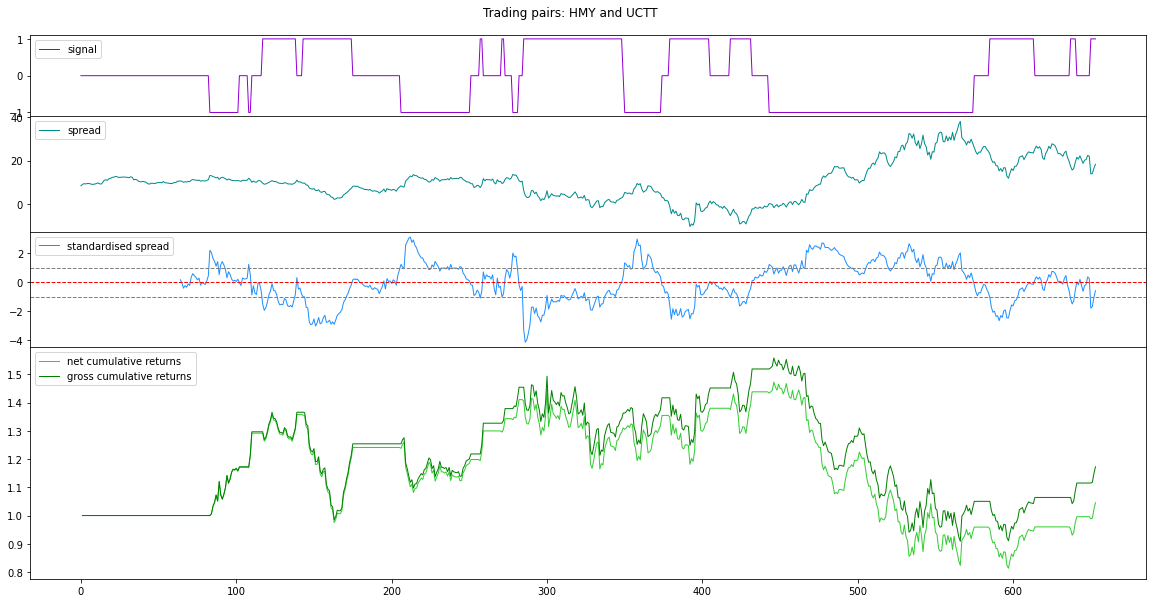

In [9]:
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(4, hspace=0, height_ratios=[0.7, 1, 1, 2])
axs = gs.subplots(sharex=True)
fig.suptitle('Trading pairs: ' + str(tickers[0]) + ' and ' + str(tickers[1]), y=0.92)
axs[0].plot(df_['signals'], lw=1, label='signal', c='darkviolet')
axs[1].plot(df_['spread'], lw=1, label='spread', c='darkcyan')
axs[2].plot(df_['z_score'], lw=1, label='standardised spread', c='dodgerblue')
axs[2].axhline(y=1, xmin=0, xmax=1, linestyle='--', color='grey', lw=1)
axs[2].axhline(y=0, xmin=0, xmax=1, linestyle='--', color='r', lw=1)
axs[2].axhline(y=-1, xmin=0, xmax=1, linestyle='--', color='grey', lw=1)
axs[3].plot(df_['net_cum_returns'], lw=1, label='net cumulative returns', c='limegreen')
axs[3].plot(df_['gross_cum_returns'], lw=1, label='gross cumulative returns', c='green')

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()
    ax.legend(loc='upper left')

### Вычислительный эксперимент 

In [10]:
list0 = np.load('pump_and_dump/pairs_list0.npy', allow_pickle=True).tolist()
list1 = np.load('pump_and_dump/pairs_list1.npy', allow_pickle=True).tolist()
list2 = np.load('pump_and_dump/pairs_list2.npy', allow_pickle=True).tolist()

In [88]:
def cum_rets_test(list0, w, df):
    cum_returns = []
    half_lives = []
    for i in tqdm(range(len(list0))):
        tickers = list0[i]
        x = df[tickers[0]]
        y = df[tickers[1]]
        df_, halflife = KF_trade(x, y, window=w)
        net_cum_rets = df_['net_cum_returns'].to_numpy()
        cum_returns.append(net_cum_rets)
        half_lives.append(halflife)
    if w!=None:
        return cum_returns
    else:
        return cum_returns, half_lives

In [36]:
def plot_rets(cum_returns):
    colormap = plt.cm.gist_ncar
    colors = [colormap(i) for i in np.linspace(0, 1,len(cum_returns))]
    plt.figure(figsize=(20, 8))
    for i, rets in enumerate(cum_returns):
        plt.plot(rets, lw=1, c=colors[i])
    plt.show()

### Cтандартное окно размером в 21 день для всех пар

#### 1. Топ-100 пар, когда как минимум на одном тестов Дики-Фуллера спред стационарен, а ccm, pc - максимальны.

In [22]:
cum_returns0 = cum_rets_test(list0, w=21, df6_test)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.62it/s]


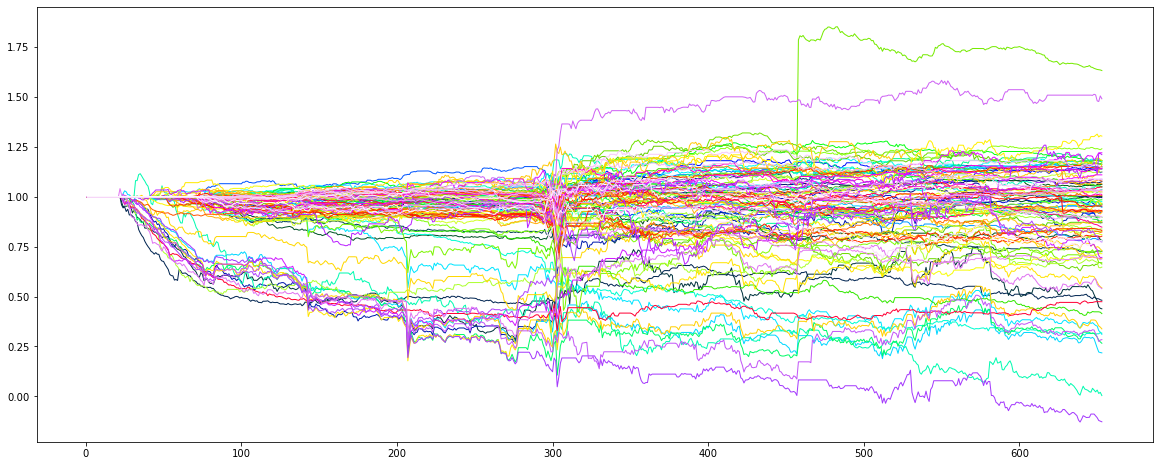

In [37]:
plot_rets(cum_returns0)

#### 2. Топ-100 пар, когда как на всех тестах Дики-Фуллера спред нестационарен, а ccm и pc - максимальны.

In [38]:
cum_returns1 = cum_rets_test(list1, w=21, df6_test)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.62it/s]


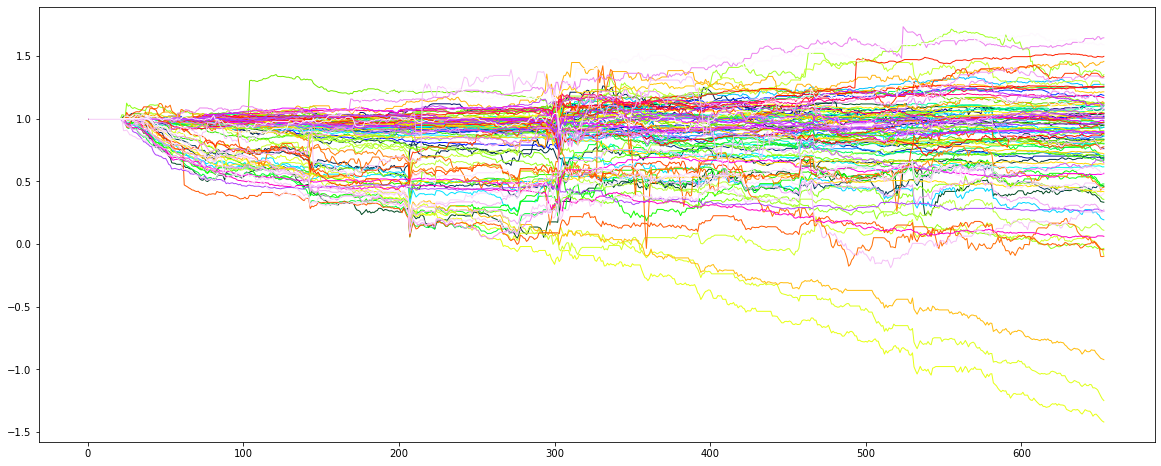

In [40]:
plot_rets(cum_returns1)

#### 3. Топ-100 пар, когда как на всех тестах Дики-Фуллера спред нестационарен, ccm - минимально, а pc - максимально.

In [39]:
cum_returns2 = cum_rets_test(list2, w=21, df6_test)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]


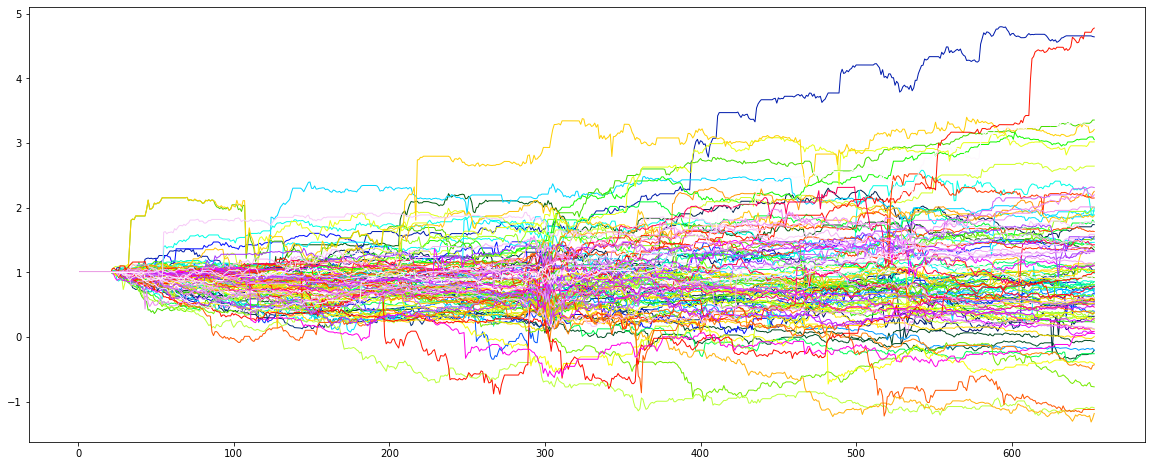

In [41]:
plot_rets(cum_returns2)

In [86]:
total_return0 = np.sum(np.array(cum_returns0)[:,-1] - 1)
total_return1 = np.sum(np.array(cum_returns1)[:,-1] - 1)
total_return2 = np.sum(np.array(cum_returns2)[:,-1] - 1)

In [87]:
total_return0, total_return1, total_return2

(-10.763050972181965, -21.98610071769454, 3.771024862891453)

In [90]:
#np.save('cum_returns0_kf_21.npy', cum_returns0)
#np.save('cum_returns1_kf_21.npy', cum_returns1)
#np.save('cum_returns2_kf_21.npy', cum_returns2)

### Cтандартное окно размером в 42 дня для всех пар

#### 1. Топ-100 пар, когда как минимум на одном тестов Дики-Фуллера спред стационарен, а ccm, pc - максимальны.

In [77]:
cum_returns0_ = cum_rets_test(list0, w=42, df6_test)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


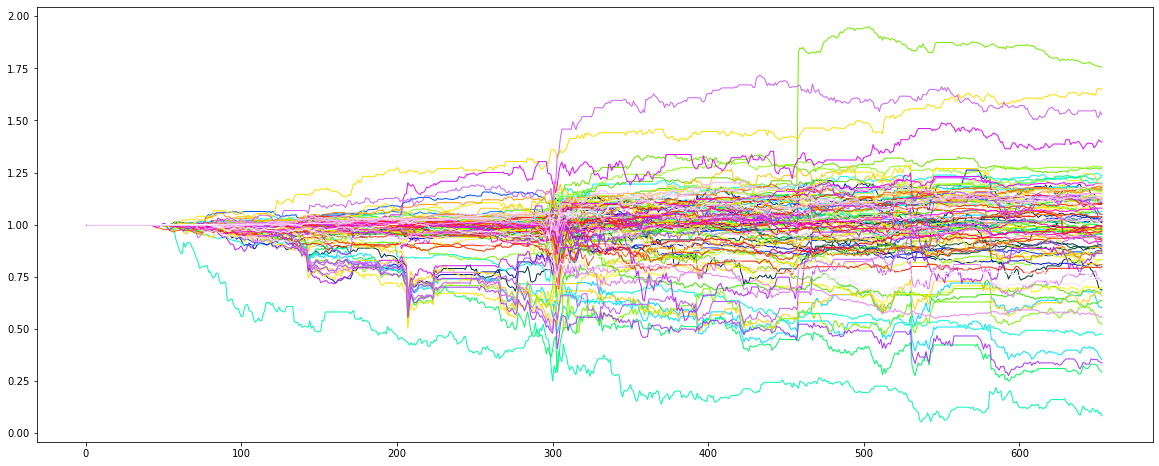

In [78]:
plot_rets(cum_returns0_)

#### 2. Топ-100 пар, когда как на всех тестах Дики-Фуллера спред нестационарен, а ccm и pc - максимальны.

In [80]:
cum_returns1_ = cum_rets_test(list1, w=42, df6_test)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


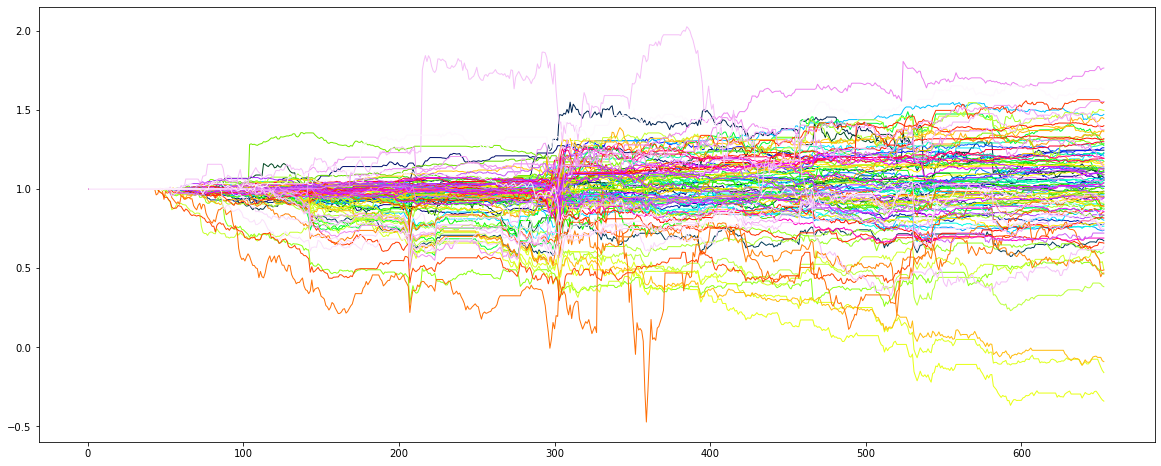

In [81]:
plot_rets(cum_returns1_)

#### 3. Топ-100 пар, когда как на всех тестах Дики-Фуллера спред нестационарен, ccm - минимально, а pc - максимально.

In [82]:
cum_returns2_ = cum_rets_test(list2, w=42, df6_test)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]


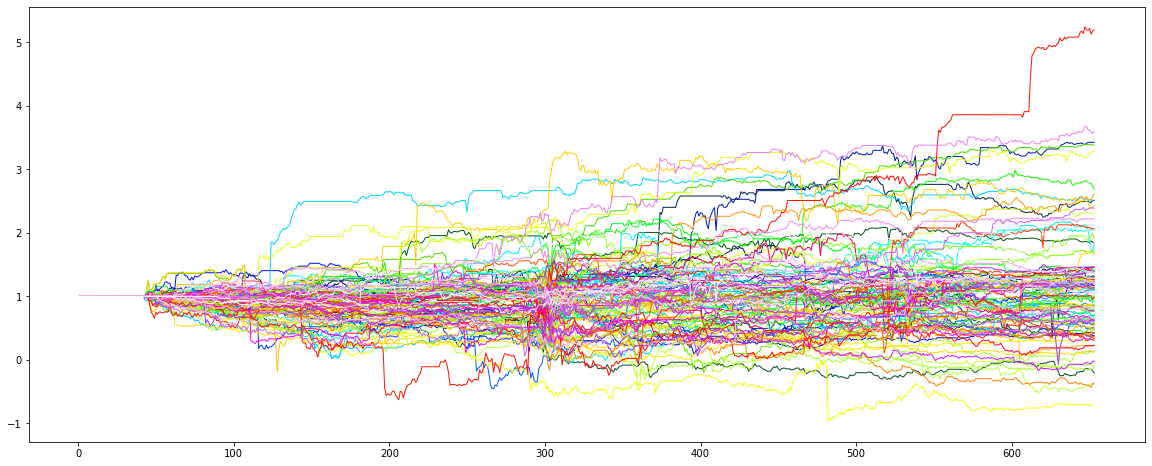

In [83]:
plot_rets(cum_returns2_)

In [84]:
total_return0_ = np.sum(np.array(cum_returns0_)[:,-1] - 1)
total_return1_ = np.sum(np.array(cum_returns1_)[:,-1] - 1)
total_return2_ = np.sum(np.array(cum_returns2_)[:,-1] - 1)

In [85]:
total_return0_, total_return1_, total_return2_

(-2.0450043160934266, -1.3647393291203016, 18.596923842129996)

In [89]:
#np.save('cum_returns0_kf_42.npy', cum_returns0_)
#np.save('cum_returns1_kf_42.npy', cum_returns1_)
#np.save('cum_returns2_kf_42.npy', cum_returns2_)